In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt

## Carga de datos

In [ ]:
df_amenaza = pd.read_csv("../../data/processed/insqui/insqui_threat_levels_k5.csv")

In [ ]:
df_vuln = pd.read_csv("../../data/processed/dane/dane.csv")

In [ ]:
# GeoDataFrame de puntos de amenaza

gdf_pts = gpd.GeoDataFrame(
    df_amenaza.copy(),
    geometry=gpd.points_from_xy(
        df_amenaza["longitud"],
        df_amenaza["latitud"]
    ),
    crs="EPSG:4326"
)

In [ ]:
# GeoDataFrame de municipios con vulnerabilidad

df_vuln["geometry"] = df_vuln["geometry"].apply(wkt.loads)

gdf_mun = gpd.GeoDataFrame(
    df_vuln,
    geometry="geometry",
    crs="EPSG:4326"
)

## Cálculo de riesgo

In [ ]:
# Join espacial para asignar vulnerabilidad a puntos de amenaza

gdf_join = gpd.sjoin(
    gdf_pts,
    gdf_mun[[
        "DPTO_CNMBR",
        "MPIO_CNMBR",
        "vuln_index",
        "vuln_index_raw",
        "geometry"
    ]],
    how="left",
    predicate="within"
)

In [ ]:
# Cálculo de riesgo

gdf_join["riesgo"] = (
    gdf_join["nivel_amenaza"] *
    gdf_join["vuln_index"]
)

In [ ]:
# Clasificación de vulnerabilidad

gdf_join["vuln_cat"] = pd.cut(
    gdf_join["vuln_index"],
    bins=[0, 0.33, 0.66, 1.0],
    labels=["Baja", "Media", "Alta"],
    include_lowest=True
)

In [ ]:
# Función para clasificar nivel de riesgo
def clasificar_riesgo(a, v):
    if a == 0:
        return "Bajo"
    if a == 1 and v == "Baja":
        return "Bajo"
    if a == 1 and v in ["Media", "Alta"]:
        return "Medio"
    if a == 2 and v == "Baja":
        return "Medio"
    if a == 2 and v in ["Media", "Alta"]:
        return "Alto"
    if a == 3:
        return "Muy Alto"
    return "Bajo"

# Aplicar clasificación de riesgo

gdf_join["nivel_riesgo_cat"] = gdf_join.apply(
    lambda r: clasificar_riesgo(r["nivel_amenaza"], r["vuln_cat"]),
    axis=1
)

# Ordenar categorías de nivel de riesgo

gdf_join["nivel_riesgo_cat"] = pd.Categorical(
    gdf_join["nivel_riesgo_cat"],
    categories=["Bajo", "Medio", "Alto", "Muy Alto"],
    ordered=True
)

# Presentación de resultados

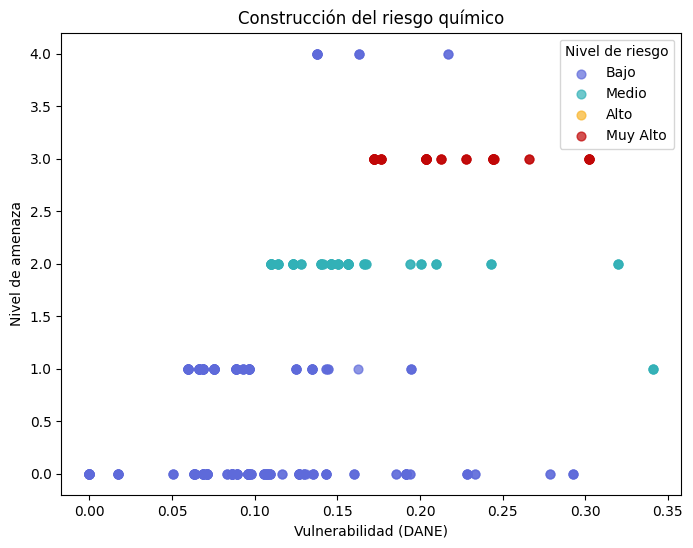

In [ ]:
# Visualización del riesgo

fig, ax = plt.subplots(figsize=(8, 6))

for cat, c in zip(orden, colors):
    d = gdf_join[gdf_join["nivel_riesgo_cat"] == cat]
    ax.scatter(
        d["vuln_index"],
        d["nivel_amenaza"],
        label=cat,
        alpha=0.7,
        s=40,
        color=c
    )

ax.set_xlabel("Vulnerabilidad (DANE)")
ax.set_ylabel("Nivel de amenaza")
ax.set_title("Construcción del riesgo químico")
ax.legend(title="Nivel de riesgo")

plt.show()


In [ ]:
# Agrupación por municipio para resumen de riesgo

res_mpio = (
    gdf_join
    .groupby(["DPTO_CNMBR", "MPIO_CNMBR"])
    .agg(
        n_puntos=("row_id", "count"),
        riesgo_max=("riesgo", "max"),
        riesgo_p95=("riesgo", lambda x: x.quantile(0.95))
    )
    .reset_index()
)

res_mpio.sort_values("riesgo_p95", ascending=False).head(10)


,DPTO_CNMBR,MPIO_CNMBR,n_puntos,riesgo_max,riesgo_p95
64,VALLE DEL CAUCA,BUENAVENTURA,6,0.906255,0.906255
60,SANTANDER,BARRANCABERMEJA,2,0.866790,0.866790
31,CESAR,VALLEDUPAR,2,0.797608,0.797608
47,CÓRDOBA,MONTERÍA,2,0.734485,0.734485
18,ATLÁNTICO,MALAMBO,8,0.731675,0.731675
22,BOLÍVAR,TURBACO,3,0.683532,0.683532
62,SANTANDER,GIRÓN,3,0.653305,0.653305
27,CAUCA,CALOTO,3,0.639651,0.639651
17,ATLÁNTICO,GALAPA,3,0.638632,0.638632
21,BOLÍVAR,CARTAGENA DE INDIAS,13,0.610545,0.610545


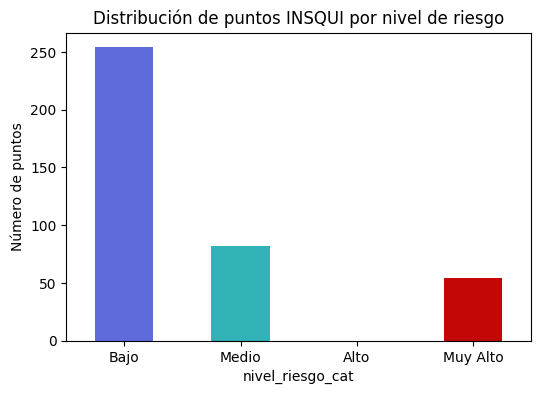

In [ ]:
# Gráfico de barras de distribución de niveles de riesgo

gdf_join["nivel_riesgo_cat"].value_counts().loc[orden].plot(
    kind="bar",
    color=colors,
    figsize=(6,4)
)

plt.title("Distribución de puntos INSQUI por nivel de riesgo")
plt.ylabel("Número de puntos")
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Agrupación por municipio para resumen de riesgo

res_mpio = (
    gdf_join
    .groupby(["DPTO_CNMBR", "MPIO_CNMBR"])
    .agg(
        n_puntos=("row_id", "count"),
        riesgo_mean=("riesgo", "mean"),
        riesgo_max=("riesgo", "max"),
        riesgo_p95=("riesgo", lambda s: s.quantile(0.95)),
    )
    .reset_index()
)

res_mpio.head()


,DPTO_CNMBR,MPIO_CNMBR,n_puntos,riesgo_mean,riesgo_max,riesgo_p95
0,ANTIOQUIA,BARBOSA,8,0.0,0.0,0.0
1,ANTIOQUIA,BELLO,2,0.0,0.0,0.0
2,ANTIOQUIA,CALDAS,7,0.0,0.0,0.0
3,ANTIOQUIA,COPACABANA,4,0.0,0.0,0.0
4,ANTIOQUIA,ENVIGADO,6,0.0,0.0,0.0


In [ ]:
# Clasificación de riesgo por municipio para mapa

x = gdf_mun_map["riesgo_p95"]

gdf_mun_map["riesgo_cat_mpio"] = pd.Series(index=gdf_mun_map.index, dtype="object")

# Bajo: exactamente cero (y también valores muy pequeños si quieres, pero aquí es == 0)
mask0 = x.fillna(np.nan) == 0
gdf_mun_map.loc[mask0, "riesgo_cat_mpio"] = "Bajo"

# Para municipios con riesgo > 0: 3 cuantiles
mask_pos = x.notna() & (x > 0)
x_pos = x[mask_pos]

if x_pos.nunique() >= 3:
    gdf_mun_map.loc[mask_pos, "riesgo_cat_mpio"] = pd.qcut(
        x_pos,
        q=3,
        labels=["Medio", "Alto", "Muy Alto"],
        duplicates="drop"
    ).astype(str)
else:
    # fallback si hay muy poca variación
    gdf_mun_map.loc[mask_pos, "riesgo_cat_mpio"] = "Alto"

# Sin datos INSQUI (municipios sin puntos): dejar como NaN para pintarlos gris
# (ya queda NaN si riesgo_p95 es NaN y no cayó en mask0)

orden = ["Bajo", "Medio", "Alto", "Muy Alto"]
gdf_mun_map["riesgo_cat_mpio"] = pd.Categorical(
    gdf_mun_map["riesgo_cat_mpio"],
    categories=orden,
    ordered=True
)


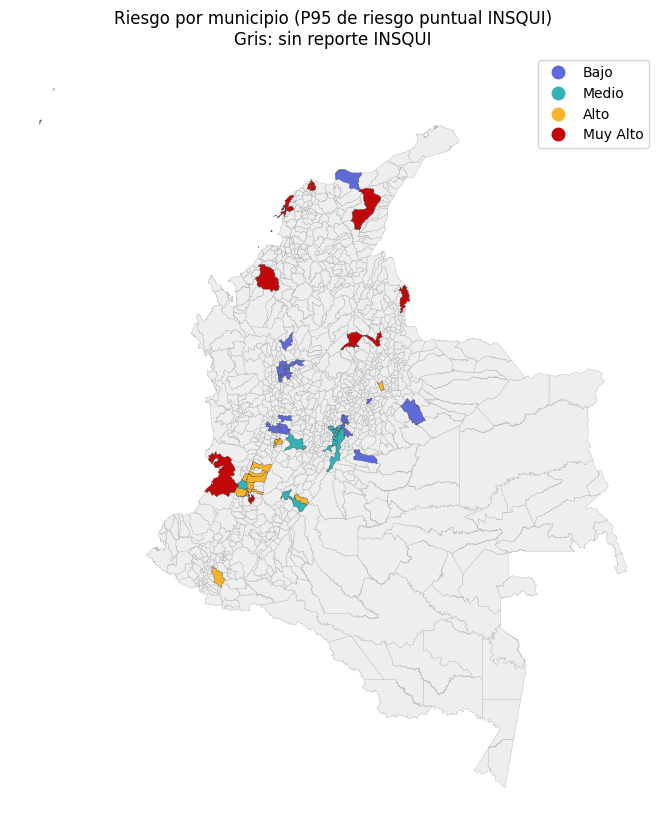

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

orden = ["Bajo", "Medio", "Alto", "Muy Alto"]
colors = ["#5E6ADA", "#32B1B7", "#F9B429", "#C10707"]
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(10, 10))

# Sin datos INSQUI
gdf_mun_map[gdf_mun_map["riesgo_cat_mpio"].isna()].plot(
    ax=ax, color="#eeeeee", edgecolor="#bbbbbb", linewidth=0.3
)

# Con datos
gdf_mun_map[gdf_mun_map["riesgo_cat_mpio"].notna()].plot(
    ax=ax,
    column="riesgo_cat_mpio",
    categorical=True,
    legend=True,
    cmap=cmap,
    edgecolor="#444444",
    linewidth=0.2
)

ax.set_title("Riesgo por municipio (P95 de riesgo puntual INSQUI)\nGris: sin reporte INSQUI")
ax.axis("off")
plt.show()


In [ ]:
# Municipios con mayor riesgo (P95)

top = (gdf_mun_map[gdf_mun_map["riesgo_p95"].notna()]
       .sort_values("riesgo_p95", ascending=False)
       [["DPTO_CNMBR","MPIO_CNMBR","n_puntos","riesgo_p95","riesgo_max","riesgo_mean"]]
       .head(15))
top


,DPTO_CNMBR,MPIO_CNMBR,n_puntos,riesgo_p95,riesgo_max,riesgo_mean
99,VALLE DEL CAUCA,BUENAVENTURA,6.0,0.906255,0.906255,0.906255
980,SANTANDER,BARRANCABERMEJA,2.0,0.866790,0.866790,0.866790
550,CESAR,VALLEDUPAR,2.0,0.797608,0.797608,0.797608
436,CÓRDOBA,MONTERÍA,2.0,0.734485,0.734485,0.734485
473,ATLÁNTICO,MALAMBO,8.0,0.731675,0.731675,0.731675
528,BOLÍVAR,TURBACO,3.0,0.683532,0.683532,0.683532
1056,SANTANDER,GIRÓN,3.0,0.653305,0.653305,0.653305
24,CAUCA,CALOTO,3.0,0.639651,0.639651,0.639651
470,ATLÁNTICO,GALAPA,3.0,0.638632,0.638632,0.638632
489,BOLÍVAR,CARTAGENA DE INDIAS,13.0,0.610545,0.610545,0.610545


In [ ]:
# Validación rápida: promedio de vulnerabilidad y amenaza por categoría de riesgo municipal

tmp = gdf_join.merge(
    gdf_mun_map[["DPTO_CNMBR","MPIO_CNMBR","riesgo_cat_mpio"]],
    on=["DPTO_CNMBR","MPIO_CNMBR"],
    how="left"
)

tmp.groupby("riesgo_cat_mpio")[["vuln_index","nivel_amenaza"]].mean()


,vuln_index,nivel_amenaza
riesgo_cat_mpio,,
Bajo,0.102970,0.000000
Medio,0.095339,1.120879
Alto,0.158457,1.953846
Muy Alto,0.213169,3.070423


In [ ]:
# Conteo de niveles de amenaza en municipios de muy alto riesgo

(tmp[tmp["riesgo_cat_mpio"]=="Muy Alto"]
 .groupby("nivel_amenaza_cat")
 .size()
 .sort_values(ascending=False))


nivel_amenaza_cat
Amenaza por clima extremo    54
Amenaza alta combinada       11
Amenaza por sismos            6
dtype: int64

## Extracción de data para dashboard

In [39]:
df_municipal = (
    gdf_mun_map
    .loc[gdf_mun_map["riesgo_p95"].notna(), [
        "DPTO_CNMBR",
        "MPIO_CNMBR",
        "riesgo_p95",
        "riesgo_cat_mpio",
        "n_puntos",
        "riesgo_mean",
        "riesgo_max",
        "vuln_index"
    ]]
    .copy()
)

df_municipal = df_municipal.copy()
df_municipal["PAIS"] = "COLOMBIA"

# Opcional: deja el orden bonito
df_municipal = df_municipal[
    ["PAIS", "DPTO_CNMBR", "MPIO_CNMBR",
     "riesgo_p95", "riesgo_cat_mpio",
     "n_puntos", "riesgo_mean", "riesgo_max", "vuln_index"]
]

df_municipal


,PAIS,DPTO_CNMBR,MPIO_CNMBR,riesgo_p95,riesgo_cat_mpio,n_puntos,riesgo_mean,riesgo_max,vuln_index
24,COLOMBIA,CAUCA,CALOTO,0.639651,Muy Alto,3.0,0.639651,0.639651,0.319825
33,COLOMBIA,CAUCA,MIRANDA,0.419343,Alto,3.0,0.419343,0.419343,0.209671
40,COLOMBIA,CAUCA,PUERTO TEJADA,0.332128,Alto,3.0,0.332128,0.332128,0.166064
57,COLOMBIA,CAUCA,VILLA RICA,0.401130,Alto,3.0,0.401130,0.401130,0.200565
58,COLOMBIA,VALLE DEL CAUCA,CALI,0.220258,Medio,11.0,0.220258,0.220258,0.110129
...,...,...,...,...,...,...,...,...,...
1115,COLOMBIA,CUNDINAMARCA,MOSQUERA,0.068527,Medio,8.0,0.068527,0.068527,0.068527
1116,COLOMBIA,CUNDINAMARCA,SIBATÉ,0.134562,Medio,6.0,0.134562,0.134562,0.134562
1117,COLOMBIA,CUNDINAMARCA,FUSAGASUGÁ,0.143099,Medio,2.0,0.143099,0.143099,0.143099
1120,COLOMBIA,ANTIOQUIA,SABANETA,0.000000,Bajo,14.0,0.000000,0.000000,0.000000


In [33]:
df_municipal.to_csv(
    "../../data/outputs/municipios_riesgo.csv",
    index=False
)

In [38]:
df_puntos = (
    gdf_join[[
        "row_id",
        "latitud",
        "longitud",
        "DPTO_CNMBR",
        "MPIO_CNMBR",
        "tipo_actividad",
        "nivel_amenaza",
        "nivel_amenaza_cat",
        "vuln_index",
        "riesgo"
    ]]
    .copy()
)

df_puntos = df_puntos.copy()
df_puntos["PAIS"] = "COLOMBIA"

df_puntos = df_puntos[
    ["PAIS", "DPTO_CNMBR", "MPIO_CNMBR",
     "latitud", "longitud",
     "tipo_actividad",
     "nivel_amenaza", "nivel_amenaza_cat",
     "vuln_index", "riesgo"]
]

df_puntos


,PAIS,DPTO_CNMBR,MPIO_CNMBR,latitud,longitud,tipo_actividad,nivel_amenaza,nivel_amenaza_cat,vuln_index,riesgo
0,COLOMBIA,VALLE DEL CAUCA,CALI,3.41,-76.53,Administrativa,2,Amenaza por sismos,0.110129,0.220258
1,COLOMBIA,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",4.62,-74.11,Administrativa,1,Amenaza por clima húmedo,0.075055,0.075055
2,COLOMBIA,CUNDINAMARCA,MOSQUERA,4.71,-74.23,Administrativa,1,Amenaza por clima húmedo,0.068527,0.068527
3,COLOMBIA,CUNDINAMARCA,COTA,4.81,-74.10,Administrativa,1,Amenaza por clima húmedo,0.088968,0.088968
4,COLOMBIA,RISARALDA,PEREIRA,4.81,-75.72,Administrativa,0,Amenaza por clima variable,0.135179,0.000000
...,...,...,...,...,...,...,...,...,...,...
385,COLOMBIA,ATLÁNTICO,GALAPA,10.90,-74.88,Producción,3,Amenaza por clima extremo,0.212877,0.638632
386,COLOMBIA,ATLÁNTICO,SOLEDAD,10.91,-74.79,Producción,3,Amenaza por clima extremo,0.176688,0.530063
387,COLOMBIA,ATLÁNTICO,BARRANQUILLA,10.98,-74.82,Producción,3,Amenaza por clima extremo,0.171893,0.515678
388,COLOMBIA,MAGDALENA,SANTA MARTA,11.23,-74.19,Producción,0,Amenaza por clima variable,0.228462,0.000000


In [37]:
df_puntos.to_csv(
    "../../data/outputs/puntos_riesgo.csv",
    index=False
)
